# Test `MDCGaussianNoise`

This notebook tests the class `MDCGaussianNoise` implemented in `likelihood.py`.

**Input needed by `MDCGaussianNoise`:**
* data : the data segment that we want to analyze. The format should be a dict() where each key represents one detector. The data for each detector should be a pycbc FrequencySeries.
* psd : the PSD of the noise (can be estimated or provided, for the moment we just provide it). Same format as *data*.

Use `data, psd = get_data.convert_to_frequency_series_with_psd(time_series, return_psd=True)` to get data and psd with the correct format from a dictionary containing gwpy time series read .gwf files.

* variable_params : a list of parameters over which we want to maximize. In the most general case it should be ['mass1', 'mass2', 'spin1z', 'spin2z', 'distance', 'polarization', 'inclination', 'tc', 'coa_phase', 'ra', 'dec'], but it is possible to reduce the number of variable parameters to make tests for example.
* static_params : a dictionary containing the parameters for which the values are already fixed (in general the spins along the x and y axes).

Note that all 15 CBC parameters must be defined, either in *variable_params* or in *static_params*.

* approximant and fmin should be defined (the default values 'IMRPhenomXPHM' and 5 Hz are fine).

**Optional input:** these are just for testing to compare the values of the parameters we recover to the injected values.
* injection_params : a dictionary contaning the parameters of the injected signal if we know them.
* injection_network_snr : the network SNR of the signal, as listed in the list of MDC signal (2nd column from the end).

**Input needed by `maximize`:**
For each variable parameter, bounds must be provided.

*Warning:* mass1 and mass2 bounds should be replaced with chirp mass and mass ratio.

## Example of workflow
#### Run within the IJCLab server :
1. Extract signal from MDC data using `extraction_temps()` and write it on a file.
#### Run within the local environment (faster than the server) :
2. Read MDC data from the file and prepare frequency domain data and PSD using `get_data.convert_to_frequency_series_with_psd()`.
3. Define variable and static params and instanciate a MDCGaussianNoise object.
4. Define bounds for each variable parameter and run the maximisation algorithm with `minimisation_globale` from `likelihood_calculation.py` or `.maximize()` directly from the class MDCGaussianNoise.
5. Compare the original data and the reconstructed signal.

In [1]:
from generate_data import generate_frequency_domain_signal, default_cbc_params
from get_data import get_psd_frequency_series, read_MDC_data, convert_to_frequency_series_with_psd, convert_data_dict_to_frequency_series_dict
from likelihood import MDCGaussianNoise, subtract_signal
from plot_results import convert_signal, comparison_signals, comparison_freq, qtrans_plot, gwpy_to_pycbc, pycbc_to_gwpy
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.size'] = 14  # global font size
from gwpy.timeseries import TimeSeries
from pycbc.types import FrequencySeries
from pycbc.types import TimeSeries as PycbcTimeSeries
from pycbc.conversions import mchirp_from_mass1_mass2, q_from_mass1_mass2, mass1_from_mchirp_q, mass2_from_mchirp_q
import sys
sys.path.append('/home/victor-glorieux/Internship_Victor_CBC_ET')
sys.path.append('/home/victor/Internship_Victor_CBC_ET')
from likelihood_calculation import minimisation_locale, minimisation_globale
from fonctions import extraction_temps, extract_mchirp_tc_spectro
from plot_functions import plot_mnimisation, plot_correlation_2_params

## To test the method - Generate signal

To generate a signal (in the frequency domain) using the functions defined in `generate_signal.py`.

In [ ]:
cbc_params = {
              'mass1': 38.6,
              'mass2': 29.3,
              'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': 0, 'spin2z': 0, 
              'eccentricity': 0,
              'ra': 1.37, 'dec': -1.26, 'distance': 10000, 
              'polarization': 2.76, 'inclination': 0,
              'tc': 3.1 , 'coa_phase': 0.3,
              'approximant': 'IMRPhenomXPHM',
              'f_lower': 5
                }
signal = generate_frequency_domain_signal(cbc_params, ifos=['E1', 'E2', 'E3'])

## 1 - Extract signal from MDC

#### !! $\underline{\text{Run within the IJCLab server}}$ !!

To read the signal between $t_\text{\ start}$ and $t_\text{\ stop}$ in the MDC using the functions defined in `get_data.py`. The data is stored in the $\texttt{gwpy}$ TimeSeries format, in the folder `data`.

The function `extraction_temps` from `fonctions.py` finds $t_0$ and $t_c$ for a specific signal thanks to `list_mdc1_v2.txt`. The type of the signal (1 : NS/NS, 2 : NS/BH, 3 : BH/BH) is asked. $\texttt{indexes}$ is the list of signals we want to analyse with the SNR decreasing as the index increases (index $_\text{min}$ = 0).

In [15]:
init, final, t0_list, tc_list, interval, params_list = extraction_temps(indexes = [0], type = 2, print_ = False)
print('Durations = ',np.array(tc_list) - np.array(t0_list))

Durations =  [1682.61544383]


In [16]:
#==========
pourcentage = 80 #Pourcentage de la durée du signal que nous supprimons depuis t0.
#==========


Delta = ((tc_list[0] - t0_list[0])/100) * pourcentage
t_start = t0_list[0] + Delta
t_stop = tc_list[0] + 0.2

ifos=['E1', 'E2', 'E3']
data = read_MDC_data(t_start, t_stop)
path_data_IJC = "/home/victor-glorieux/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/data/data_i0_t1/"
for ifo in ifos :
    data[ifo].write(path_data_IJC + "données_" +  ifo + ".txt")

Test : Creation of the $\texttt{MDCGaussianNoise}$ model defined in `likelihood.py` and data visualization in time domain.

-2520711.4297836414


/home/victor-glorieux/.conda/envs/cop_adrian/lib/python3.9/site-packages/gwpy/plot/axes.py:190: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  super().draw(*args, **kwargs)
/home/victor-glorieux/.conda/envs/cop_adrian/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


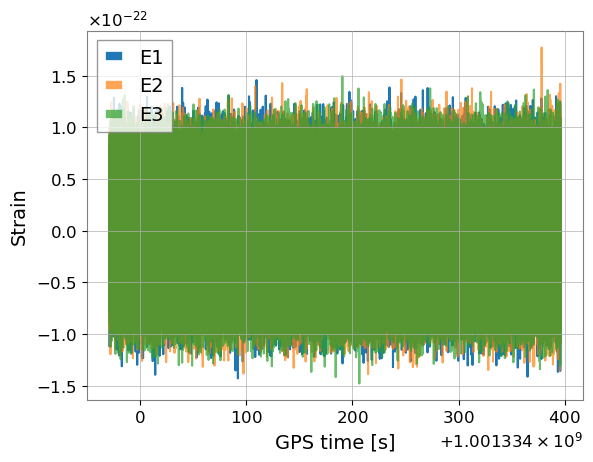

In [14]:
data_freq, psds = convert_data_dict_to_frequency_series_dict(data)
model = MDCGaussianNoise(data_freq, psds)
print(model.lognl)

plt.figure()
ax = plt.gca()
ax.plot(data['E1'].times, data['E1'], label='E1')
ax.plot(data['E2'].times, data['E2'], label='E2', alpha=0.7)
ax.plot(data['E3'].times, data['E3'], label='E3', alpha=0.7)

ax.set_xlabel('GPS time [s]')
ax.set_ylabel('Strain')
ax.legend()

## 2 - Read signal : from IJCLab server to local environment

Convert the $\texttt{gwpy}$ TimeSeries from the data stored to $\texttt{pycbc}$ TimeSeries and FrequencySeries.

- $\texttt{gwpy}$ TimeSeries : data
- $\texttt{pycbc}$ TimeSeries : pycbc_ts
- $\texttt{pycbc}$ FrequencySeries : signal

In [7]:
study_index = 10
study_type = 3

In [51]:
path_data_home = '/home/victor/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/data/data_i'+ str(study_index) +'_t'+ str(study_type) +'/'
data = {}
signal = {}
ifos=['E1', 'E2', 'E3']
for ifo in ifos:
    channel = ifo + ':STRAIN'
    file = path_data_home + 'données_' + ifo + '.txt'
    data[ifo] = TimeSeries.read(file)
    #data[ifo] = data[ifo].resample(4096)
    #data[ifo] = data[ifo].resample(2048)
    data[ifo] = data[ifo].resample(1024)
    val = data[ifo].value
    delta_t = data[ifo].dt.value
    pycbc_ts = PycbcTimeSeries(val, delta_t=delta_t)
    signal[ifo] = pycbc_ts.to_frequencyseries()

fft, psd = convert_to_frequency_series_with_psd(data['E1'], return_psd=True)
data_freq, psds = convert_data_dict_to_frequency_series_dict(data)

In [52]:
model = MDCGaussianNoise(data_freq, psds)
print(model.lognl)

-48326.31521981521


## 3 - Create MDCGaussianNoise model

#### ! $\underline{\text{Run within the local environment}}$ ! to gain efficiency.

We instanciate an MDCGaussianNoise object with the signal we have generated and the PSD used for the ET MDC.

Since there is no noise, we verify that the optimal log likelihood is 0 and the optimal log likelihood ratio corresponds to 1/2 of the network SNR. Here "optimal" means "computed for the true parameters of the injected CBC signal".

**Variable and static parameters:**
* Variable parameters are the ones that we want to maximize over. They are provided as a list.
* Static parameters are fixed: they are provided as a dictionary with known values.

All CBC parameters defined in *cbc_params* must be either in *variable_params* or defined in *static_params*. The approximant and lower frequency are always static.

In [ ]:
#psd = get_psd_frequency_series(signal['E1'].get_sample_frequencies(), signal['E1'].get_delta_f())
#psds = {'E1': psd, 'E2': psd, 'E3': psd}

cbc_params = {
              'mass1': 38.6,
              'mass2': 29.3,
              'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': 0, 'spin2z': 0, 
              'eccentricity': 0,
              'ra': 1.37, 'dec': -1.26, 'distance': 10000, 
              'polarization': 2.76, 'inclination': 0,
              'tc': 3.1 , 'coa_phase': 0.3,
              'approximant': 'IMRPhenomXPHM',
              'f_lower': 5
                }

variable_params = ['mass1', 'mass2','spin1z', 'spin2z', 'ra', 'dec', 'distance', 'polarization', 'inclination', 'tc', 'coa_phase']
static_params = dict(cbc_params)
for param in variable_params :
    del static_params[param]


# We know the signal parameters so we can define injection_params and compute optimal likelihoods
model = MDCGaussianNoise(signal, psds, fmin=5, approximant='IMRPhenomXPHM', variable_params=variable_params,\
                         static_params=static_params)

#optimal_loglr, optimal_loglikelihood = model.compute_optimal_likelihoods()
#print('Optimal log likelihood ratio: ' + format(optimal_loglr, '.2f'))
# print('Optimal log likelihood: ' + format(optimal_loglikelihood, '.2f'))

#snr_network_sq = model.det_optimal_snrsq('E1') + model.det_optimal_snrsq('E2') + model.det_optimal_snrsq('E3')
#print('1/2 network SNR: ' + format(0.5 * snr_network_sq, '.2f'))

True signal parameters unknown. Cannot compute optimal likelihood.
Optimal log likelihood ratio: -1.00


## 4 - Maximize the likelihood

The method `maximize()` calls `scipy.optimize.differential_evolution()`. We can specify the maximal number of iterations and the tolerance, which are parameters of `differential_evolution()`. This method automatically defines the bounds on the parameters over which to maximize, with a radius of 10% from the true values (for example if the true chirp mass is 30, it will restrict the chirp mass in the range 27, 33). When doing the full analysis of the MDC, we will use greater bounds since we are not supposed to know the true values of the injected signal.

In [49]:
ET_params = pd.read_csv("/home/victor/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/data/loudest_BBH/list_mdc1_v2.txt",sep = ' ',engine='python', index_col = False)
ET_params = ET_params.sort_values('snr',ascending=False) #Sélectionne les events avec le meilleur SNR pour les indices les plus faibles.
ET_params = ET_params[ET_params['type'] == study_type] #Sélectionne un type particulier d'événements.
params_list = ET_params.iloc[study_index]

mchirp_signal = mchirp_from_mass1_mass2(params_list.mz1,params_list.mz2)
q_signal = q_from_mass1_mass2(params_list.mz1,params_list.mz2)

print(mchirp_signal)
print(params_list.tc)

36.90186553775064
1001372606.533215


In [ ]:
dict = extract_mchirp_tc_spectro(data,'E1',show_fit=True)
print(dict["mchirp"])
print(dict["tc"])

In [12]:
#Nelder-Mead,  Powell, L-BFGS-B
#differential_evolution, basinhopping
mass1_init = 30
mass2_init = 30
mchirp = mchirp_from_mass1_mass2(mass1_init,mass2_init)
q = q_from_mass1_mass2(mass1_init,mass2_init)
initial_params = [params_list.tc - 1, mchirp_signal+1, q_signal-0.1,  params_list.distMpc - 100,       0,      0,    0,       0,    0,       0, 0]

pi2 = np.pi/2
dpi = 2*np.pi
#       t0                                   chirp                             q                           dist                                              ra      dec        pol     incl      s1z          s2z          co_ph
bounds=((params_list.tc-2,params_list.tc+2),(mchirp_signal-30,mchirp_signal+30),(q_signal-0.5,q_signal+0.5),(params_list.distMpc-500,params_list.distMpc+500),(0,dpi),(-pi2,pi2),(0,dpi),(0,np.pi),(-0.95,0.95),(-0.95,0.95),(0,pi2))

start_time = time.time()
file_name = 'lik_calculation_i'+ str(study_index) +'_t'+ str(study_type) +'.txt'
result_glob = minimisation_globale(model=model,initial_params = initial_params,bounds=bounds,method="SLSQP",minimisation='differential_evolution',
                                   tol=0.001,nb_iter=100,maxiter=10000, stepsize = 0.1, log_noise_likelihood_from_SNR=0,
                                   normalisation=False,save_data=True,file_name=file_name)
duration_code = time.time() - start_time
print(result_glob)

Iteration 793: negative_loglr = -31208.7836607231
             message: Optimization terminated successfully.
             success: True
                 fun: -31208.7836607231
                   x: [ 1.001e+09  5.968e+01  1.029e+00  3.801e+03
                        1.809e+00  1.208e+00  4.045e+00  3.826e-01
                        3.442e-02 -1.747e-01  1.488e-01]
                 nit: 793
                nfev: 131106
          population: [[ 1.001e+09  5.968e+01 ... -1.747e-01  1.488e-01]
                       [ 1.001e+09  5.979e+01 ... -1.327e-01  1.905e-01]
                       ...
                       [ 1.001e+09  5.966e+01 ... -1.716e-01  2.318e-01]
                       [ 1.001e+09  5.971e+01 ... -1.814e-01  1.464e-01]]
 population_energies: [-3.121e+04 -3.116e+04 ... -3.118e+04 -3.119e+04]


In [14]:
list_result = result_glob.x
mass1 = mass1_from_mchirp_q(list_result[1],list_result[2])
mass2 = mass2_from_mchirp_q(list_result[1],list_result[2])
result_DF = pd.DataFrame(data={'time_mini' : duration_code, 'mloglik': result_glob.fun, 'tc': list_result[0], 'mass1': mass1,
                        'mass2': mass2, 'distance': list_result[3], 'ra' : list_result[4],
                        'dec' : list_result[5], 'polarization': list_result[6], 'inclination': list_result[7],
                        'spin1z' : list_result[8], 'spin2z' : list_result[9], 'coa_phase': list_result[10],
                        'chirp' : list_result[1], 'q' : list_result[2]},index=[0])


file_result = 'result_i'+ str(study_index) +'_t' + str(study_type)
result_DF.to_csv('/home/victor/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/results_mini/' + file_result, index = False)

## 5 - Reconstruc the optimized signal and analysis

Plots : all plot functions come from `plot_results.py`
- Time domain comparison of the reconstructed signal and the injected signal form the MDC : `comparison_signals()`
- Frequency domain comparison of the reconstructed signal and the injected signal form the MDC : `comparison_freq()`
- Q-transforms of the signal and the residuals : `qtrans()`

In [ ]:
file_name = 'result_i'+ str(study_index) +'_t' + str(study_type)
signal_reconstructed_t, signal_reconstructed_f = convert_signal(file_name=file_name, epoch=data['E1'].t0.value)
tspycbc_data = gwpy_to_pycbc(data)

start_common = max(signal_reconstructed_t['E1'].start_time, data['E1'].t0.value)
end_common = min(signal_reconstructed_t['E1'].end_time, data['E1'].t0.value + data['E1'].duration.value)
opti_cut = {}
reel_cut = {}
residual = {}
print(signal_reconstructed_t)
for ifo in ifos :
    opti_cut[ifo] = signal_reconstructed_t[ifo].time_slice(start_common, end_common)
    reel_cut[ifo] = tspycbc_data[ifo].time_slice(start_common, end_common)
    #reel_cut[ifo] = tspycbc_data[ifo]
    residual[ifo] = PycbcTimeSeries(opti_cut[ifo] - reel_cut[ifo], epoch = start_common)


Waveform approximate duration: 9.7s
Segment duration: 16.0s
{'E1': <pycbc.types.timeseries.TimeSeries object at 0x77f5b5370c70>, 'E2': <pycbc.types.timeseries.TimeSeries object at 0x77f599833250>, 'E3': <pycbc.types.timeseries.TimeSeries object at 0x77f5b56f99d0>}


In [ ]:
file_name='result_i'+ str(study_index) +'_t' + str(study_type)
params_opti_file = pd.read_csv('/home/victor/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/results_mini/' + file_name)

comparison_signals(params_opti_file,signal_reconstructed_t,tspycbc_data,residual,position = "Front",ifo = 'E2')

In [ ]:
comparison_freq(signal_reconstructed_t,tspycbc_data,residual,ifo = 'E2')

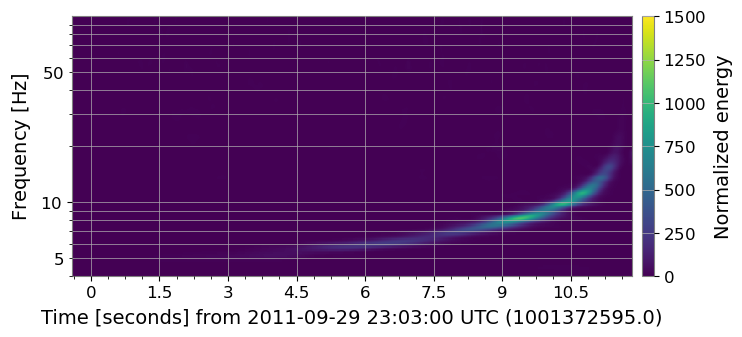

In [66]:
tsgwpy_opti_cut = pycbc_to_gwpy(opti_cut)
tsgwpy_reel_cut = pycbc_to_gwpy(reel_cut)
# plt.plot(tsgwpy_opti_cut['E1'].times.value,tsgwpy_opti_cut['E1'],zorder=4,label='opti')
# plt.plot(tsgwpy_reel_cut['E1'].times.value,tsgwpy_reel_cut['E1'],zorder=3,label='reel')
# plt.legend()
qtrans_plot(tsgwpy_reel_cut['E1'],frange = (4, 100),qrange = (5, 30),colorbar_limits = {'inf' : 0, 'sup' :1500})

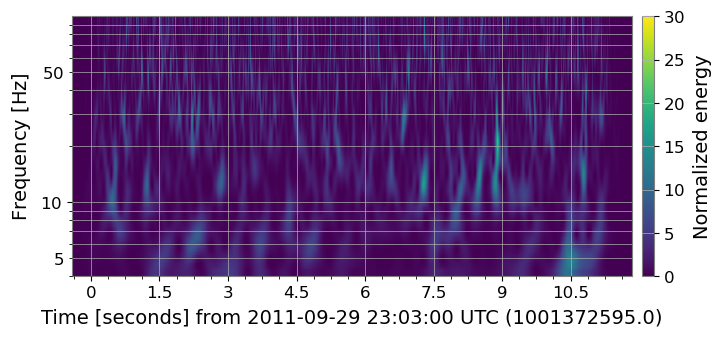

In [71]:
tsgwpy_res = pycbc_to_gwpy(residual)
qtrans_plot(tsgwpy_res['E1'],frange = (4, 100),qrange = (5, 30),colorbar_limits = {'inf' : 0, 'sup' : 30})

### Computing time

* The longer the signal is, the longer it takes to generate it and therefore maximize the likelihood. CBC signals become longer when we decrease the minimal frequency and/or the chirp mass.
* For the ET MDC, we would ideally want to go down to a minimal frequency of 5 Hz and chirp mass of 1.21 solar masses. In this case the signal lasts more than 6000s. It is possible that it takes too much computing time. If that's the case, we could decide to increase the minimal frequency to keep the computing cost manageable.